## To run this colab, press the "Runtime" button in the menu tab and then press the "Run all" button.

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
# from __future__ import absolute_import, division, print_function, unicode_literals
# !pip install tf-nightly-gpu-2.0-preview

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.14.0


## Setup Input Pipeline

Download the Rust dataset from my drive


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

E0708 13:45:21.678500 140523192534912 ultratb.py:152] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-cd0a7580851e>", line 3, in <module>
    get_ipython().magic('cd /gdrive')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "</usr/local/lib/python3.6/dist-packages/decorator.py:decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/m

OSError: ignored

In [0]:
import os
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/gdrive/My Drive/rustimages/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
local_zip = '/gdrive/My Drive/rustimages/testt.zip' 
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp2')
zip_ref.close()

In [0]:
TRAINING_DIR = "/tmp/data/"

train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split = 0.3)



train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=60,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    subset='training')


validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                              batch_size=60,
                                                              class_mode='categorical',
                                                              target_size=(224, 224),
                                                              subset='validation')


Found 3798 images belonging to 2 classes.
Found 1627 images belonging to 2 classes.


Use `ImageDataGenerator` to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((60, 224, 224, 3), (60, 2))

Save the labels in a file which will be downloaded later.

In [0]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

labels

{'notRust': 0, 'rust': 1}


'notRust\nrust'

In [0]:
!cat labels.txt

cat: labels.txt: No such file or directory


## Create the base model from the pre-trained convnets

Create the base model from the **VGG19**  

VGG-19 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 19 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224

ImageNet dataset is a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate a new model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [0]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG19
base_model = tf.keras.applications.vgg19.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')


W0708 09:35:16.122951 140523192534912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


80142336/80134624 [==============================] - 7s 0us/step


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 20,171,938
Trainable params: 147,554
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [0]:
from tensorflow import keras

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1)
]

### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 100

history = model.fit(train_generator, 
                    epochs=epochs,
                    callbacks = callbacks,
                    validation_data=validation_generator)

Epoch 1/100
64/64 [==============================] - 95s 1s/step - loss: 0.4317 - acc: 0.8607 - val_loss: 0.2697 - val_acc: 0.8931
Epoch 2/100
64/64 [==============================] - 83s 1s/step - loss: 0.1516 - acc: 0.9394 - val_loss: 0.2742 - val_acc: 0.8869
Epoch 3/100
64/64 [==============================] - 83s 1s/step - loss: 0.0963 - acc: 0.9634 - val_loss: 0.1647 - val_acc: 0.9355
Epoch 4/100
64/64 [==============================] - 83s 1s/step - loss: 0.0873 - acc: 0.9671 - val_loss: 0.1490 - val_acc: 0.9385
Epoch 5/100
64/64 [==============================] - 82s 1s/step - loss: 0.0767 - acc: 0.9768 - val_loss: 0.2800 - val_acc: 0.9017
Epoch 6/100
64/64 [==============================] - 82s 1s/step - loss: 0.0784 - acc: 0.9721 - val_loss: 0.1217 - val_acc: 0.9521
Epoch 7/100
64/64 [==============================] - 83s 1s/step - loss: 0.0660 - acc: 0.9758 - val_loss: 0.1350 - val_acc: 0.9478
Epoch 8/100
64/64 [==============================] - 82s 1s/step - loss: 0.0600 - a

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

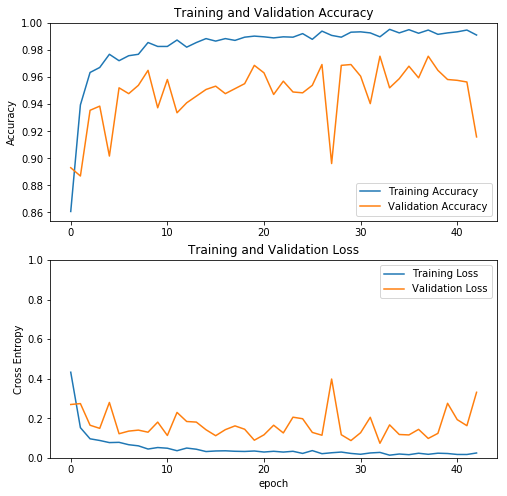

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  22


### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 20,171,938
Trainable params: 20,171,938
Non-trainable params: 0
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 36


### Continue Train the model

In [0]:
history_fine = model.fit(train_generator, 
                         epochs=200,
                         callbacks = callbacks,
                         validation_data=validation_generator)

Epoch 1/200
64/64 [==============================] - 162s 3s/step - loss: 0.0385 - acc: 0.9868 - val_loss: 0.2061 - val_acc: 0.9435
Epoch 2/200
64/64 [==============================] - 147s 2s/step - loss: 0.0198 - acc: 0.9939 - val_loss: 0.1572 - val_acc: 0.9662
Epoch 3/200
64/64 [==============================] - 148s 2s/step - loss: 0.0266 - acc: 0.9908 - val_loss: 0.0597 - val_acc: 0.9834
Epoch 4/200
64/64 [==============================] - 148s 2s/step - loss: 0.0097 - acc: 0.9971 - val_loss: 0.0606 - val_acc: 0.9859
Epoch 5/200
64/64 [==============================] - 148s 2s/step - loss: 0.0244 - acc: 0.9937 - val_loss: 0.0751 - val_acc: 0.9717
Epoch 6/200
64/64 [==============================] - 148s 2s/step - loss: 0.0074 - acc: 0.9976 - val_loss: 0.2103 - val_acc: 0.9484
Epoch 7/200
64/64 [==============================] - 148s 2s/step - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0917 - val_acc: 0.9674
Epoch 8/200
64/64 [==============================] - 148s 2s/step - loss: 0.

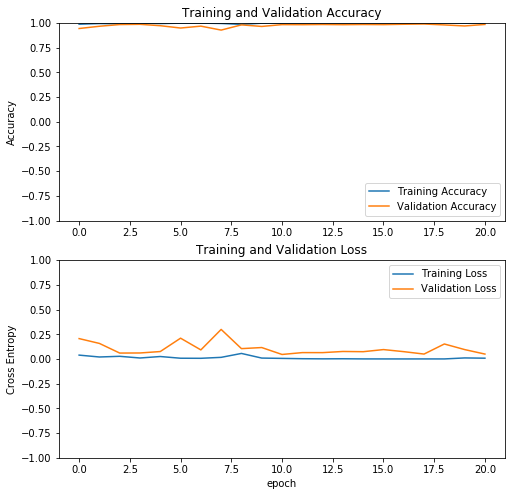

In [0]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [0]:
# saved_model_dir = 'save/fine_tuning'
# tf.saved_model.save(model, saved_model_dir)

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# tflite_model = converter.convert()

# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

Download the converted model and labels

In [0]:
# from google.colab import files

# files.download('model.tflite')
# files.download('labels.txt')

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


In [0]:
classes = {0 : "Chlorophytum comosum", 1 : 'ficus benjamina' , 2 : "philodendron"}
# {'Chlorophytum comosum': 0, 'Ficus Benjamina': 1, 'bromeliads': 2}

In [0]:
# from keras.preprocessing import image
# import numpy as np
# from keras.applications.inception_v3 import preprocess_input, decode_predictions
# from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg




# f = plt.figure(figsize=(10,10))

# # print (f)
# img_path = '1.jpg'
# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)
# img=mpimg.imread(img_path)
# f.add_subplot(221)

# plt.imshow(img)


# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) )


# img_path = 't2.jpg'
# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)
# img=mpimg.imread(img_path)
# f.add_subplot(222)

# plt.imshow(img)

# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) )


# img_path = 't3.JPG'
# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)
# img=mpimg.imread(img_path)
# f.add_subplot(223)

# plt.imshow(img)

# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) )

# img_path = 't4.jpg'
# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)
# img=mpimg.imread(img_path)
# f.add_subplot(224)

# plt.imshow(img)

# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)







# plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) )





# f = plt.figure(figsize=(5,5))


# img_path = 'planti.jfif'
# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)
# img=mpimg.imread(img_path)


# plt.imshow(img)

# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) )


In [0]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    "/tmp2/testt/",
    batch_size=1,
    class_mode='categorical',
    target_size=(224, 224))

Found 22 images belonging to 2 classes.


In [0]:
predict = model.evaluate_generator(test_generator,steps = 20)

In [0]:
predict

[2.943786273068744, 0.8]

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
from google.colab import drive
drive.mount('/gdrive')

model_save_name = 'model2.h5'
path = F"/gdrive/My Drive/rustimages/{model_save_name}" 
model.save(path)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:

predictions = model.predict(test_generator)
print(model.evaluate(test_generator))
# Print our model's predictions.
print(np.argmax(predictions, axis=1)) 
print (train_generator.class_indices)


37/37 [==============================] - 1s 33ms/step - loss: 0.0247 - acc: 1.0000
[0.0246756860725201, 1.0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'notRust': 0, 'rust': 1}
